In [1]:
import numpy as np

"""Initialize gensim embeddings for joined, full and pretrained, dim 100"""

from gensim.models import KeyedVectors, Word2Vec

def print_similar(model: KeyedVectors) -> None:
    # todo: retrain vectors uncased!!!
    print('Checking similar words:')
    for word in ['przekonywujący', 'złodzieji', 'swetr', 'ludzią']:
      most_similar = ', '.join('%s (%.2f)' % (similar, dist)
                               for similar, dist in model.most_similar(word)[:8])
      print('  %s -> %s' % (word, most_similar))

In [2]:
def save_vectors(model_path: str, vecs_path: str) -> None:
    model = Word2Vec.load(model_path)
    vecs = model.wv
    vecs.save(vecs_path)

In [3]:
# save_vectors(model_path='../ckpt/joined/sg_100/sg_100_model', vecs_path='../ckpt/joined/sg_100/sg_100.kv')

In [32]:
import time
# joined_cbow_model = Word2Vec.load('../ckpt/joined/cbow_100/cbow_100_model')
# cbow_vectors = joined_cbow_model.wv
# cbow_vectors.save('../ckpt/joined/cbow_100/cbow_100_vectors.kv')
joined_cbow_model = KeyedVectors.load('../ckpt/joined/cbow_100/cbow_100_vectors.kv')
print("CBOW model on joined dataset")
start_time1 = time.time()
print_similar(joined_cbow_model)
print("--- %s seconds ---" % (time.time() - start_time1))
# print()
joined_skipgram_model = KeyedVectors.load('../ckpt/joined/sg_100/sg_100.kv')
print("SkipGram model on joined dataset")
print_similar(joined_skipgram_model)

CBOW model on joined dataset
Checking similar words:
  przekonywujący -> argumentowania (0.82), ariunbaatar (0.81), niezręczny (0.81), actn (0.81), najefektywniejszy (0.81), finezyjny (0.80), niejednoznaczny (0.80), potażnia (0.80)
  złodzieji -> partyzantach (0.80), jakościach (0.79), gębach (0.78), aymerica (0.78), pedia­try (0.77), abecednom (0.77), redosledusuprotno (0.77), cięszkich (0.77)
  swetr -> 23022009r (0.87), 20102008r (0.87), lubańlubawkalublinłebałódźmielnomiędzywodziemiędzyzdrojemikołajkimikoszewomiłkówmrągowomurzasichlemuszynanadolenałęczównidzicanieborówniechorzeniedzicanowa (0.86), niepiarżysty (0.86), അസ്‌ലഹ് (0.86), 手机 (0.86), f8f (0.86), nieurodzony (0.86)
  ludzią -> mhzzasilanie (0.67), ka¿dej (0.67), cospie (0.66), cigu (0.66), orazbeatelmania (0.66), trpimirowiczów (0.65), 140220 (0.65), duszego (0.65)
--- 0.6775708198547363 seconds ---
SkipGram model on joined dataset
Checking similar words:
  przekonywujący -> kumają (0.95), śmiertelnikom (0.95), nieskromna

In [5]:
def word2idx(word, model):
  return model.key_to_index[word]


def idx2word(idx, model):
  return model.index_to_key[idx]

In [6]:
import pandas as pd

def read_ds_to_df(filepath: str) -> pd.DataFrame:
    with open(filepath, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    label_mapping = {'label__z_zero': 0, 'label__z_amb': 2, 'label__z_minus_m': 3, 'label__z_plus_m': 1}
    test_dict = {}
    for line in lines:
        line_spl = line.split(' __')
        test_dict[line_spl[0].strip()] = line_spl[1].strip()
    test_dict = {k:label_mapping[v] for (k, v) in test_dict.items()}
    df = pd.DataFrame.from_dict(test_dict, orient='index').reset_index()
    return df.rename(columns={'index': 'text', 0: 'label'})

In [7]:
path_to_test = '../data/emb_test_data/all.sentence.test.txt'
test = read_ds_to_df(path_to_test)
test.head()

,text,label
0,Potrafi przyczepic sie do wszystkie - osie sym...,3
1,"Lokalizacja w centrum - przy głównym deptaku ,...",1
2,"Komórki te odpowiadają za resorpcję kości , cz...",0
3,Jedzenie było smaczne poza tak jak pisał em wc...,2
4,Po zamianie leku na inny kaszel natychmiast us...,2


In [8]:
path_to_dev = '../data/emb_test_data/all.sentence.dev.txt'
dev = read_ds_to_df(path_to_dev)
dev.head()

,text,label
0,Moim zdaniem jest wart jakieś 1100zł .,3
1,co jest masakra szczególnie jak na początku ch...,3
2,Poza tym krzesło ma bardzo duże luzy .,3
3,"Ścielenie łóżek , sprzątanie sal po organizowa...",0
4,Parę niższych osób siedziało i było im wygodnie .,2


In [9]:
path_to_train = '../data/emb_test_data/all.sentence.train.txt'
train = read_ds_to_df(path_to_train)
train.head()

,text,label
0,"Taksowak przyjezdza na czas , wydaje sie , ze ...",0
1,Do tej pani trafili śmy z naszą 2 - miesięczna...,0
2,"Wyróżnikiem , a także ciekawym elementem całeg...",0
3,"W zależności od pory dnia , w naszych organizm...",0
4,"Polecam wszystkim , zwłaszcza tym , dla któryc...",1


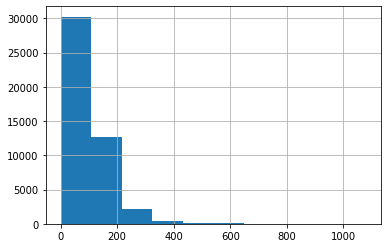

count    45935.000000
mean       100.884010
std         77.040292
min          1.000000
25%         50.000000
50%         83.000000
75%        129.000000
max       1078.000000
dtype: float64

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

reviews_len = [len(x) for x in train['text']]
pd.Series(reviews_len).hist()
plt.show()
pd.Series(reviews_len).describe()

In [11]:
def remove_outliers(df: pd.DataFrame) -> pd.DataFrame:
    mask = (df['text'].apply(lambda x: 20 < len(str(x).split(' ')) <= 250))
    return df.loc[mask]

In [12]:
from typing import List
from gensim.utils import tokenize

"""Ignoring unknown tokens, as they might be creating additional noise to the model performance"""

def get_tokenized_x(df: pd.DataFrame, model: KeyedVectors) -> List[List[str]]:
    X = df['text'].tolist()
    X = [list(tokenize(sentence)) for sentence in X]
    result = []
    for sentence in X:
        indices = []
        for word in sentence:
            if word.lower() in list(model.index_to_key):
                indices.append(word2idx(word.lower(), model))
        result.append(indices)
    return result

In [13]:
print(train.shape)
train = remove_outliers(train)
print(train.shape)

(45935, 2)
(13863, 2)


In [14]:
dev = remove_outliers(dev)

In [15]:
test = remove_outliers(test)

In [16]:
import torch
from typing import Tuple
from torch.utils.data import Dataset
from sklearn.preprocessing import OneHotEncoder

class ClassificationDataset(Dataset):
    """Class inheriting after torch dataset,
    reads the data, encodes the input and target as tensors
    pads them to max length
    the overriden getitem returns a tensor tuple of input and target
    """
    def __init__(self, texts, labels, model_path = '../ckpt/joined/cbow_100/cbow_100_vectors.kv'):
        self.texts = texts
        self.labels = labels
        self.model = KeyedVectors.load(model_path)
        embeddings = torch.Tensor(self.model.vectors)
        self.embedding = torch.nn.Embedding.from_pretrained(embeddings=embeddings)

    def __len__(self):
        return len(self.texts)

    def embed(self, sentence: str) -> torch.Tensor:
        tokens = list(tokenize(sentence))
        tokens = [word2idx(word=tok.lower(), model=self.model) for tok in tokens if tok in self.model.key_to_index.keys()]
        tokens = torch.LongTensor(tokens)
        embedded = self.embedding(tokens)
        return embedded.cuda()

    def __getitem__(self, index):
        sentence = self.texts[index]
        label = self.labels[index]
        label = torch.tensor(label, dtype=torch.long)
        return self.embed(sentence), label

In [17]:
from typing import List
import torch
import torch.nn as nn


class LSTM(nn.Module):

    def __init__(self, num_layers: int,
                 num_classes: int, dimension=100,
                 model_path: str = '../ckpt/joined/cbow_100/cbow_100_vectors.kv'):
        super(LSTM, self).__init__()

        self.dimension = dimension
        self.lstm = nn.LSTM(input_size=dimension,
                            hidden_size=dimension,
                            num_layers=num_layers,
                            batch_first=True,
                            bidirectional=False)
        self.dropout = nn.Dropout(p=0.5)

        self.linear = nn.Linear(dimension, num_classes)
        self.emb_model = KeyedVectors.load(model_path)

    def forward(self, batch):
        output, hidden_states = self.lstm(batch)
        out_forward = output[:, -1]
        text_features = self.dropout(out_forward)

        text_logits = self.linear(text_features)
        text_logits = text_logits[:,:]
        probs = torch.sigmoid(text_logits)

        return probs

In [18]:
train_ds = ClassificationDataset(train['text'].to_numpy(), train['label'].to_numpy())
dev_ds = ClassificationDataset(dev['text'].to_numpy(), dev['label'].to_numpy())
test_ds = ClassificationDataset(test['text'].to_numpy(), test['label'].to_numpy())

In [19]:
from torch.utils.data import DataLoader
from typing import Tuple, Union
from tqdm import tqdm
import torch
import torch.nn as nn

def count_correct(
    y_pred: torch.Tensor, y_true: torch.Tensor,
) -> torch.Tensor:
    preds = torch.argmax(y_pred, dim=1)
    return (preds == y_true).float().sum()

def validate(
    model: nn.Module,
    loss_fn: Union[torch.nn.CrossEntropyLoss, torch.nn.BCELoss],
    dataloader: DataLoader,
    is_binary: bool = False
) -> Tuple[torch.Tensor, torch.Tensor]:
    loss = 0
    correct = 0
    all = 0
    for X_batch, y_batch in dataloader:
        y_pred = model(X_batch)
        all += len(y_pred)
        loss += loss_fn(y_pred, y_batch.cuda()).sum()
        correct += count_correct(y_pred, y_batch.cuda())
    return loss / all, correct / all

def fit(
        model: nn.Module,
        optimiser: torch.optim.Optimizer,
        loss_fn: torch.nn.CrossEntropyLoss,
        train_dl: DataLoader,
        val_dl: DataLoader,
        epochs: int,
        print_metrics: str = True,
):
  for epoch in range(epochs):
      model.train()
      for X_batch, y_batch in tqdm(train_dl):
          y_pred = model(X_batch)
          loss = loss_fn(y_pred, y_batch.cuda())

          loss.backward()
          optimiser.step()
          optimiser.zero_grad()

      if print_metrics:
          model.eval()
          with torch.no_grad():
              train_loss, train_acc = validate(
                  model=model, loss_fn=loss_fn, dataloader=train_dl
              )
              val_loss, val_acc = validate(
                  model=model, loss_fn=loss_fn, dataloader=val_dl
              )
              print(
                  f"Epoch {epoch}: "
                  f"train loss = {train_loss:.3f} (acc: {train_acc:.3f}), "
                  f"validation loss = {val_loss:.3f} (acc: {val_acc:.3f})"
              )

In [20]:
def collate_fn(batch):
    sequences = [b[0] for b in batch]
    labels = [b[1] for b in batch]
    sequences = sorted(sequences, key=lambda x: x.shape[0], reverse=True)
    sequences_padded = torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True)
    return sequences_padded, torch.stack(labels)

In [21]:
model_CBOW = LSTM(num_layers=2, num_classes=4).cuda()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_CBOW.parameters(), lr=0.001)
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(dev_ds, batch_size=64, shuffle=True, collate_fn=collate_fn)

In [22]:
batch = next(iter(val_dl))
type(batch[0])

torch.Tensor

In [23]:
batch[0]

tensor([[[ 9.2296e-01,  5.4049e-01, -1.7758e-01,  ..., -1.5364e-01,
          -7.0579e-02,  7.3740e-01],
         [ 4.8692e+00, -4.1691e-01,  4.6085e-01,  ..., -2.7845e-01,
          -1.4422e+00,  1.5397e+00],
         [ 6.0732e+00, -1.7143e+00, -1.9337e+00,  ..., -1.9084e+00,
           3.3864e-01, -1.4694e+00],
         ...,
         [ 8.3325e-01, -5.7760e-01, -4.1955e-01,  ...,  2.3566e-01,
          -2.0078e-01, -7.5610e-02],
         [ 3.5230e-01,  3.0727e-01, -5.0487e-02,  ..., -2.5199e-01,
          -1.0895e-01,  1.3289e-01],
         [ 5.9534e-02,  5.4448e-01,  1.0775e+00,  ...,  9.0538e-01,
           8.6923e-01,  2.8426e-01]],

        [[ 3.6850e+00, -1.2062e+00, -2.6835e+00,  ...,  1.1382e+00,
          -8.2648e-02, -1.4407e+00],
         [ 5.4467e+00, -5.2929e-01, -1.1692e+00,  ...,  4.9529e-01,
          -9.8189e-01,  3.3662e-01],
         [ 6.1459e-01, -1.6662e-01, -3.3168e-02,  ...,  4.0492e-02,
          -1.2076e-01,  2.7654e-01],
         ...,
         [ 0.0000e+00,  0

In [24]:
batch[1]

tensor([0, 0, 1, 3, 3, 1, 3, 3, 1, 3, 3, 3, 0, 1, 1, 3, 1, 3, 2, 1, 2, 3, 0, 1,
        0, 3, 1, 0, 0, 1, 1, 2, 1, 0, 3, 3, 1, 0, 0, 3, 2, 0, 3, 2, 1, 3, 1, 3,
        3, 3, 2, 3, 3, 3, 3, 2, 3, 3, 3, 0, 0, 3, 3, 3])

In [37]:
batch[1].shape

torch.Size([64])

In [38]:
fit(model=model_CBOW,
    optimiser=optimizer,
    loss_fn=criterion,
    train_dl=train_dl,
    val_dl=val_dl,
    epochs=50)

100%|██████████| 217/217 [00:05<00:00, 41.06it/s]


Epoch 0: train loss = 0.021 (acc: 0.383), validation loss = 0.020 (acc: 0.394)


100%|██████████| 217/217 [00:04<00:00, 53.17it/s]


Epoch 1: train loss = 0.021 (acc: 0.383), validation loss = 0.020 (acc: 0.394)


100%|██████████| 217/217 [00:04<00:00, 53.17it/s]


Epoch 2: train loss = 0.021 (acc: 0.383), validation loss = 0.020 (acc: 0.394)


100%|██████████| 217/217 [00:04<00:00, 48.22it/s]


Epoch 3: train loss = 0.021 (acc: 0.383), validation loss = 0.021 (acc: 0.394)


100%|██████████| 217/217 [00:04<00:00, 52.89it/s]


Epoch 4: train loss = 0.021 (acc: 0.383), validation loss = 0.020 (acc: 0.394)


100%|██████████| 217/217 [00:04<00:00, 53.20it/s]


Epoch 5: train loss = 0.021 (acc: 0.383), validation loss = 0.020 (acc: 0.394)


 54%|█████▍    | 118/217 [00:02<00:02, 48.25it/s]


KeyboardInterrupt: 

In [39]:
model_SG = LSTM(num_layers=2, num_classes=4, model_path='../ckpt/joined/sg_100/sg_100.kv').cuda()
optimizer_SG = torch.optim.Adam(model_SG.parameters(), lr=0.001)

In [96]:
fit(model=model_SG,
    optimiser=optimizer_SG,
    loss_fn=criterion,
    train_dl=train_dl,
    val_dl=val_dl,
    epochs=50)

  0%|          | 0/217 [00:00<?, ?it/s]


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [25]:
from torch.nn import Linear, ReLU, Sigmoid
from torch.nn.init import kaiming_uniform_, xavier_uniform_


class ClassificationMLP(torch.nn.Module):
    def __init__(self, n_inputs):
        super().__init__()
        self.hidden1 = Linear(n_inputs, 20)
        kaiming_uniform_(self.hidden1.weight, nonlinearity='relu')
        self.act1 = ReLU()
        # Second hidden layer
        self.hidden2 = Linear(20, 10)
        kaiming_uniform_(self.hidden2.weight, nonlinearity='relu')
        self.act2 = ReLU()
        # Third hidden layer
        self.hidden3 = Linear(10,1)
        # xavier_uniform_(self.hidden3.weight)
        self.act3 = Sigmoid()

    def forward(self, x):
        x = self.hidden1(x)
        x = self.act1(x)
        # Second hidden layer
        x = self.hidden2(x)
        x = self.act2(x)
        # Third hidden layer
        x = self.hidden3(x)
        x = self.act3(x)
        return torch.squeeze(x)

In [43]:
mlp = ClassificationMLP(n_inputs=100).cuda()
optimizerMLP = torch.optim.Adam(params=mlp.parameters(), lr=0.01)
fit(model=mlp,
    optimiser=optimizerMLP,
    loss_fn=criterion,
    train_dl=train_dl,
    val_dl=val_dl,
    epochs=15)

100%|██████████| 217/217 [00:03<00:00, 68.65it/s]


Epoch 0: train loss = 0.059 (acc: 0.275), validation loss = 0.060 (acc: 0.288)


100%|██████████| 217/217 [00:03<00:00, 71.77it/s]


Epoch 1: train loss = 0.059 (acc: 0.276), validation loss = 0.060 (acc: 0.285)


100%|██████████| 217/217 [00:02<00:00, 72.77it/s]


Epoch 2: train loss = 0.059 (acc: 0.278), validation loss = 0.060 (acc: 0.288)


100%|██████████| 217/217 [00:03<00:00, 68.44it/s]


Epoch 3: train loss = 0.059 (acc: 0.279), validation loss = 0.060 (acc: 0.287)


100%|██████████| 217/217 [00:02<00:00, 72.38it/s]


Epoch 4: train loss = 0.059 (acc: 0.281), validation loss = 0.060 (acc: 0.282)


100%|██████████| 217/217 [00:03<00:00, 68.45it/s]


Epoch 5: train loss = 0.059 (acc: 0.279), validation loss = 0.060 (acc: 0.285)


100%|██████████| 217/217 [00:03<00:00, 71.65it/s]


Epoch 6: train loss = 0.059 (acc: 0.279), validation loss = 0.060 (acc: 0.284)


100%|██████████| 217/217 [00:03<00:00, 72.04it/s]


Epoch 7: train loss = 0.059 (acc: 0.280), validation loss = 0.060 (acc: 0.287)


100%|██████████| 217/217 [00:02<00:00, 72.91it/s]


Epoch 8: train loss = 0.059 (acc: 0.281), validation loss = 0.060 (acc: 0.290)


100%|██████████| 217/217 [00:03<00:00, 71.73it/s]


Epoch 9: train loss = 0.059 (acc: 0.279), validation loss = 0.060 (acc: 0.285)


100%|██████████| 217/217 [00:03<00:00, 71.05it/s]


Epoch 10: train loss = 0.059 (acc: 0.278), validation loss = 0.059 (acc: 0.290)


100%|██████████| 217/217 [00:03<00:00, 71.76it/s]


Epoch 11: train loss = 0.059 (acc: 0.279), validation loss = 0.060 (acc: 0.288)


100%|██████████| 217/217 [00:02<00:00, 73.14it/s]


Epoch 12: train loss = 0.059 (acc: 0.280), validation loss = 0.060 (acc: 0.286)


100%|██████████| 217/217 [00:02<00:00, 73.15it/s]


Epoch 13: train loss = 0.059 (acc: 0.279), validation loss = 0.060 (acc: 0.285)


100%|██████████| 217/217 [00:02<00:00, 72.73it/s]


Epoch 14: train loss = 0.059 (acc: 0.280), validation loss = 0.060 (acc: 0.285)


In [29]:
train_ds_sg = ClassificationDataset(train['text'].to_numpy(), train['label'].to_numpy(), '../ckpt/joined/sg_100/sg_100.kv')
dev_ds_sg = ClassificationDataset(dev['text'].to_numpy(), dev['label'].to_numpy(), '../ckpt/joined/sg_100/sg_100.kv')
test_ds_sg = ClassificationDataset(test['text'].to_numpy(), test['label'].to_numpy(), '../ckpt/joined/sg_100/sg_100.kv')

In [30]:
train_dl_sg = DataLoader(train_ds_sg, batch_size=64, shuffle=True, collate_fn=collate_fn)
val_dl_sg = DataLoader(dev_ds_sg, batch_size=64, shuffle=True, collate_fn=collate_fn)

In [31]:
mlp_sg = ClassificationMLP(n_inputs=100).cuda()
optimizerMLP = torch.optim.Adam(params=mlp_sg.parameters(), lr=0.01)
fit(model=mlp_sg,
    optimiser=optimizerMLP,
    loss_fn=criterion,
    train_dl=train_ds_sg,
    val_dl=val_dl_sg,
    epochs=15)

 11%|█         | 1476/13863 [00:05<00:47, 259.76it/s]


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [26]:
train_ds_pr = ClassificationDataset(texts=train['text'].to_numpy(),
                                    labels=train['label'].to_numpy(),
                                    model_path='../ckpt/pretrained/word2vec_100_3_polish.bin')
dev_ds_pr = ClassificationDataset(texts=train['text'].to_numpy(),
                                  labels=train['label'].to_numpy(),
                                  model_path='../ckpt/pretrained/word2vec_100_3_polish.bin')
test_ds_pr = ClassificationDataset(texts=train['text'].to_numpy(),
                                   labels=train['label'].to_numpy(),
                                   model_path='../ckpt/pretrained/word2vec_100_3_polish.bin')

In [27]:
train_dl_pr = DataLoader(train_ds_pr, batch_size=64, shuffle=True, collate_fn=collate_fn)
val_dl_pr = DataLoader(dev_ds_pr, batch_size=64, shuffle=True, collate_fn=collate_fn)

In [28]:
mlp_pr = ClassificationMLP(n_inputs=100).cuda()
optimizerMLP = torch.optim.Adam(params=mlp_pr.parameters(), lr=0.01)
fit(model=mlp_pr,
    optimiser=optimizerMLP,
    loss_fn=criterion,
    train_dl=train_dl_pr,
    val_dl=val_dl_pr,
    epochs=15)

100%|██████████| 217/217 [00:03<00:00, 63.80it/s]


Epoch 0: train loss = 0.051 (acc: 0.276), validation loss = 0.051 (acc: 0.278)


100%|██████████| 217/217 [00:03<00:00, 66.77it/s]


Epoch 1: train loss = 0.051 (acc: 0.280), validation loss = 0.051 (acc: 0.281)


100%|██████████| 217/217 [00:03<00:00, 66.79it/s]


Epoch 2: train loss = 0.051 (acc: 0.280), validation loss = 0.051 (acc: 0.280)


100%|██████████| 217/217 [00:03<00:00, 67.18it/s]


Epoch 3: train loss = 0.051 (acc: 0.281), validation loss = 0.051 (acc: 0.279)


100%|██████████| 217/217 [00:03<00:00, 70.45it/s]


Epoch 4: train loss = 0.051 (acc: 0.280), validation loss = 0.051 (acc: 0.280)


100%|██████████| 217/217 [00:03<00:00, 69.79it/s]


Epoch 5: train loss = 0.051 (acc: 0.281), validation loss = 0.051 (acc: 0.280)


100%|██████████| 217/217 [00:03<00:00, 63.84it/s]


Epoch 6: train loss = 0.051 (acc: 0.280), validation loss = 0.051 (acc: 0.280)


100%|██████████| 217/217 [00:03<00:00, 67.85it/s]


Epoch 7: train loss = 0.051 (acc: 0.281), validation loss = 0.051 (acc: 0.280)


100%|██████████| 217/217 [00:03<00:00, 70.48it/s]


Epoch 8: train loss = 0.051 (acc: 0.281), validation loss = 0.051 (acc: 0.281)


100%|██████████| 217/217 [00:03<00:00, 67.09it/s]


Epoch 9: train loss = 0.051 (acc: 0.281), validation loss = 0.051 (acc: 0.280)


100%|██████████| 217/217 [00:03<00:00, 68.21it/s]


Epoch 10: train loss = 0.051 (acc: 0.281), validation loss = 0.051 (acc: 0.281)


100%|██████████| 217/217 [00:03<00:00, 68.55it/s]


Epoch 11: train loss = 0.051 (acc: 0.280), validation loss = 0.051 (acc: 0.280)


100%|██████████| 217/217 [00:03<00:00, 68.41it/s]


Epoch 12: train loss = 0.051 (acc: 0.281), validation loss = 0.051 (acc: 0.281)


100%|██████████| 217/217 [00:03<00:00, 69.09it/s]


Epoch 13: train loss = 0.051 (acc: 0.281), validation loss = 0.051 (acc: 0.281)


100%|██████████| 217/217 [00:03<00:00, 67.89it/s]


Epoch 14: train loss = 0.051 (acc: 0.281), validation loss = 0.051 (acc: 0.280)


In [35]:
embeddings = joined_cbow_model.vectors
embeddings = torch.Tensor(embeddings)
emb = torch.nn.Embedding.from_pretrained(embeddings)
emb

Embedding(1929043, 100)

In [38]:
embeddings_pr_model = KeyedVectors.load('../ckpt/pretrained/word2vec_100_3_polish.bin')
embeddings_pr = embeddings_pr_model.vectors
embeddings_pr = torch.Tensor(embeddings_pr)
emb_pr = torch.nn.Embedding.from_pretrained(embeddings_pr)
emb_pr

Embedding(1934030, 100)

In [37]:
embeddings = joined_skipgram_model.vectors
embeddings = torch.Tensor(embeddings)
emb = torch.nn.Embedding.from_pretrained(embeddings)
emb

Embedding(1929043, 100)

In [39]:
print_similar(embeddings_pr_model)

Checking similar words:


c:\users\test\appdata\local\programs\python\python38\lib\site-packages\gensim\models\keyedvectors.py:850: RuntimeWarning: invalid value encountered in true_divide
  dists = dot(self.vectors[clip_start:clip_end], mean) / self.norms[clip_start:clip_end]


  przekonywujący -> przekonywujące (0.81), przekonywający (0.79), przekonywującym (0.79), przekonujący (0.77), oględny (0.76), przekonywującego (0.76), przekonywująca (0.73), nieprzekonujący (0.72)
  złodzieji -> aprochowa (0.57), gliksiusza (0.57), wyłudzenie (0.55), roegnera (0.52), damiensa (0.52), konkolitanos (0.51), euniosa (0.51), razieli (0.51)
  swetr -> gabardynowy (0.60), cajgowy (0.60), kamgarn (0.60), flanelowy (0.59), bezrękawnik (0.59), drelichowy (0.59), popelinowy (0.59), czechczery (0.59)


KeyError: "Key 'ludzią' not present in vocabulary"